# Тестирование гипотез

Проверка односторонних и двусторонних гипотез с использование асимптотического z-критерия, t-статистики. 
- Повышает ли наличие личного местоимения в цитате количество лайков под ней
- Проверка партии товаров на брак с помощью тестирования гипотез и выборочной дисперсии
- Анализ рейтинга президента США
- Знают ли кошки свое имя
- Зависит ли вероятность отчисления из-за мат анализа от степени доброты преподавателя
- Всегда ли бутерброд падает маслом вниз

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Тестирование гипотезы о количестве лайков под разными цитатами

Есть предположение, что если в цитате есть личные местоимения, то пользователь автоматически сопоставляет себя автору этой цитаты и вероятность того, что она будет лайкнута, повышается. Например, цитату 

> Можно простить человеку все, кроме отсутствия. (Экзюпери) 

Хочется лайкнуть меньше, чем

> Мне наплевать, что вы обо мне думаете. Я о вас вообще не думаю. (Булгаков)  

В табличке `df_vk_wise` лежат данные о цитатах из [группы Вконтакте](https://vk.com/ooioioioioioo) В колонке `I` находится переменная, которая принимает значение `True`, когда в тексте цитаты было личное местоимение "Я".

Срежем первые $50$ постов, так как под ними количество репостов и лайков ещё окончательно не выставлено, и будем работать с остатками. 

In [3]:
df = pd.read_csv('df_vk_wise.csv')[50:]
df.head()

,likes,reposts,text,I
50,549,25,"Я, говорит, люблю человечество, но дивлюсь на ...",True
51,607,22,"Нельзя любить то, что я люблю, да ещё так, как...",True
52,914,37,Если испытываешь по-настоящему глубокое чувств...,False
53,989,34,"— Я тебя люблю, — сказал я. \n— Это пройдет, —...",True
54,1229,32,"Он очаровательно рассказывает мне о том, как о...",False


Построим гистограмму для числа лайков постов, содержащих личные местоимения и не содержащих.

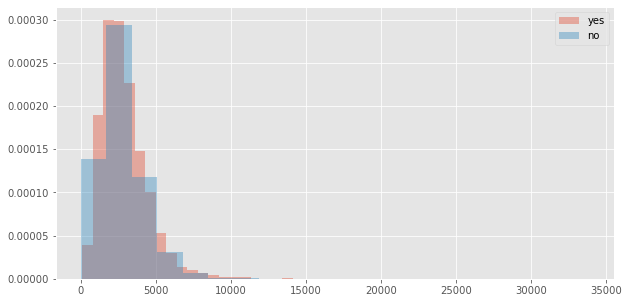

In [5]:
x = df[df['I']== True]['likes'].values
y = df[df['I']== False]['likes'].values

plt.figure(figsize=(10,5))
plt.hist(x, bins=20, density=True, alpha=0.4, label='yes')
plt.hist(y, bins=20, density=True, alpha=0.4, label='no')
plt.legend();

В распределениях есть проблемы. Это выбросы. Хвосты на гистограммах оказываются очень длинными. Найдем медианы и средние для числа лайков. Сравним их между собой. 

In [7]:
np.mean(x), np.median(x)

(2879.1828885400314, 2588.5)

In [6]:
np.mean(y), np.median(y)

(2784.0432051478474, 2497.0)

Проверим гипотезу о равенстве среднего числа репостов. Используем для этого $z$-тест, основанный на ЦПТ. Стандартное отклонение расчитаем по выборке, используя несмещённую оценку. Запишем наблюдаемое значение статистики в переменную `z_obs`. 

In [8]:
alpha = 0.05 

diff = x.mean() - y.mean() 
diff_std = np.sqrt(x.var(ddof=1)/x.size + y.var(ddof=1)/y.size)
z_obs = diff/diff_std
z_obs

2.6644610922505323

Найдем критическое значение статистики. Сравним его с наблюдаемым. Рассчитаем `p_value` для ситуации с двусторонней альтернативой.

In [9]:
z_crit = sts.norm.ppf(1 - alpha/2)
pval = 2*sts.norm.cdf(-z_obs)
z_crit, pval

(1.959963984540054, 0.00771117860544288)

__Вывод:__ p-value оказывается меньше уровня значимости (5%), что означает, что гипотеза о том, что среднее число лайков в случае использования личного местоимения и не использования равно, отвергается. То есть использование личного местоимения оказывает ненулевой эффект на среднее число лайков

Можно заметить, что у распределения числа репостов длинные хвосты. В данных есть выбросы, которые завышают среднее значение. Если выбросы сильные, то ЦПТ может ломаться. Из-за этого имеет смысл в данном случае проверять гипотезу о равенстве медиан, которые устойчивы к выбросам.

-------------------

## Тестирование гипотезы о большом количестве бракованных изделий в партии

Партия мыла считается хорошей, если дисперсия размера изделия не превышает $25$ грамм. Измеряется $10$ кусков мыла. Выборочная дисперсия равна $27$ грамм. Можно ли продавать эту партию или её надо списать в брак? 

Проверим гипотезу о том, что партия не является бракованной, на 1% уровне значимости

In [10]:
# H0: s <= 25
# Ha: s > 25

s0 = 25
n = 10
s2 = 27

chi_obs = (n - 1)*s2/s0
chi_rv = sts.chi(n - 1)
chi_cr = chi_rv.ppf(1 - alpha)
 
pval1 = 1 - sts.norm.cdf(chi_obs)
chi_obs, chi_cr, pval1

(9.72, 4.1132684819520895, 0.0)

__Вывод:__ p-value больше 1% (уровня значимости), значит, гипотеза, что партию можно продавать, не отвергается. Кроме того, наблюдаемое значение статистики меньше критического, что также свидетельствует о том, что данные не противоречат нулевой гипотезе

Для того, чтобы уменьшить количество бракованного мыла, компания собирается внедрить новую технологию производства. Было произведено по старой технологии $100$ кусков мыла. Стандартное отклонение этой партии составило $6$ грамм. Для  новой технологии стандартное отклонение, посчитанное по $100$ кускам мыла, составило $5$ грамм. Правда ли, что новая технология обладает меньшей дисперсией и её нужно внедрить на производстве?

При проверке гипотезы используем уровень значимости $1\%$.

In [11]:
nx, ny = 100, 100 
s1, s2 = 6,5
F_obs = s1/s2
f_rv = sts.f(nx - 1, ny - 1) 
F_crit = f_rv.ppf(1 - alpha/2)
pval2 = 1 - f_rv.cdf(F_obs)
F_obs, F_crit, pval2

(1.2, 1.4862337676192938, 0.18296405416652783)

## Анализ рейтинга президента

В таблице `presidents.csv` представлены рейтинги различных президентов США. Социальные опросы проводились раз в квартал. Опрашивалась случайная выборка граждан. У каждого спрашивалось одобряет ли он деятельность президента.

Ричард Никсон был президентом США с 20 января 1969 года по 9 августа 1974 года. 17 июня 1972 года произошёл Уотергейтский скандал. Проанализируем, что при этом произошло с его рейтингом.

In [11]:
df = pd.read_csv('presidents.csv')
df.head()

,year,Qtr1,Qtr2,Qtr3,Qtr4
0,1945,NaN,87,82.0,75.0
1,1946,63.0,50,43.0,32.0
2,1947,35.0,60,54.0,55.0
3,1948,36.0,39,NaN,NaN
4,1949,69.0,57,57.0,51.0


Вытащим из таблицы рейтинг Никсона с 1 квартала 1969 года по 2 квартал 1972 года (включая его) - переменная `x`. Рейтинг с 3 квартала 1972 года по 2 квартал 1974 года - перменная `y`. Пропуски в данных удалим из выборки.

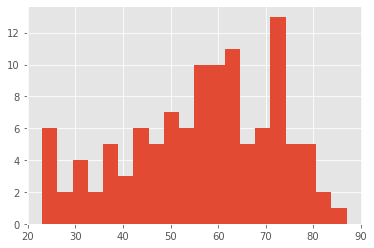

In [12]:
df_melt = pd.melt(df, id_vars=['year'], value_vars=['Qtr1','Qtr2','Qtr3','Qtr4'])
df_melt['variable'] = df_melt['variable'].apply(lambda w: int(w[-1]))
df_melt.sort_values(['year', 'variable'], inplace=True)
df_melt.reset_index(drop=True, inplace=True)

x_mn = df_melt[df_melt['year'] == 1969].index[0]
x_mx = df_melt[df_melt['year'] == 1972].index[2]

y_mn = df_melt[df_melt['year'] == 1972].index[2]
y_mx = df_melt[df_melt['year'] == 1974].index[2]

x = df_melt[x_mn:x_mx].dropna().value.values
y = df_melt[y_mn:y_mx].dropna().value.values

x.size, y.size 

df_melt.value.hist(bins=20);

Правда ли, что после скандала средний рейтинг Никсона рухнул? Предположим, что рейтинг распределён нормально, а также, что дисперсия рейтинга не изменилась из-за скандала.

In [13]:
from statsmodels.stats.weightstats import ttest_ind
obs, pval, _ = ttest_ind(x, y, value=0, alternative='larger')
obs, pval

(3.5640741313229793, 0.0011087344846424454)

__Вывод:__ p-value меньше 5%, значит, нулевая гипотеза отвергается (изменение рейтинга отлично от нуля) на урвоне значиммости 5%. К тому же, наблюдаемое знапчение статистики больше критического знаечния, что свидетельствует об отвержении нулевой гипотезы.

## Тестирование снотворного

Проводится эксперимент о пользе нового снотворного. Для его проведения используется группа из $10$ студентов. В первый день каждый из них ложится спать. На утро измеряется, сколько он проспал. Из результата вычитают $8$ (нормальное число часов сна). На второй день каждому дают таблетку. Утром снова измеряют сколько человек проспал, и вычитают $8$. Результаты эксперимента записаны в табличку `sleep.csv`.

In [12]:
df = pd.read_csv('sleep.csv')
df.head()

,extra,group,ID
0,0.7,1,1
1,-1.6,1,2
2,-0.2,1,3
3,-1.2,1,4
4,-0.1,1,5


Правда ли, что сон студентов до приёма снотворного не отличается от нормы (отклонение от 8 часов равно нулю). Проверим эту гипотезу на $5\%$ уровне значимости.

In [35]:
x = df[df['group'] == 1]['extra']
len(x)

10

In [37]:
x = df[df['group'] == 1]['extra']


n = len(x)
mu = x.mean()
std = x.std(ddof=1)/np.sqrt(n)

t_obs = (mu - 0)/std
t_crit = sts.t(n - 1).ppf(1 - alpha/2)
pval1 = 2*sts.t(n - 1).cdf(-t_obs)
t_obs, pval1

(1.3257101407138216, 0.2175977800684488)

__Вывод:__ сон студентов до приема снотворного не отличается от нормы, так как гипотеза о нулевоми отклонении не отвергается на уровне значимости 5%

Правда ли, что благодаря таблеткам студенты стали спать больше (односторонняя альтернатива)? Запишите в переменную `pval2` соотвествующее p-значение. 

In [38]:
x = df[df['group'] == 1].extra.values
y = df[df['group'] == 2].extra.values

d = y - x
n = d.size
mu = d.mean()
std = d.std(ddof=1)/np.sqrt(n)

t_obs = (mu - 0)/std
t_crit = sts.t(n - 1).ppf(1 - alpha)
pval2 = sts.t(n - 1).cdf(-t_obs)

t_obs, pval2

(4.062127683382037, 0.001416445098692135)

__Вывод:__ p-value меньше 5% (уровня значимости), значит, нулевая гипотеза об отсутствии изменений в продолжительности сна отвергается в пользу того, что студенты стали спать больше. К тому же, наблюдаемое значение больше критического, а это значит, что наблюдаемое значение попало в хвост и нулевая гипотеза отвергается. Данные не противоречат тому, что студенты стали спать болше

## Распознают ли кошки своем имя

Многие владельцы кошек уверены, что их питомцы могут понимать достаточно большое количество слов, а также узнавать собственное имя. Однако долгое время никто не пытался доказать это экспериментально. Разобраться с этой проблемой [решили учёные из Токийского университета.](https://nplus1.ru/news/2019/04/04/cat-name?utm_source=obrazovach&utm_medium=social&utm_campaign=yaponskie-uchenye-dokazali--chto-domashnie-k)

Было проведено четыре эксперимента с участием домашних кошек и кошек из кошачьих кафе. Учёные использовали метод привыкания-отвыкания (habituation-dishabituation), который часто используется в экспериментах с участием маленьких детей. 

В соответствии с гипотезой, которая лежит в основе этого метода, определить реакцию на какой-либо стимул можно, представив его после схожих с ним стимулов. К примеру, для того, чтобы выяснить, может ли младенец узнать свое имя, ему представляют несколько слов подряд: с каждым новым словом его реакция снижается, но появление имени должно (в случае, если ребенок действительно узнает свое имя) ее вернуть. Этот же метод применили и к кошкам: реакция кошек на слова характеризовалась поворотом головы, движением ушей, вокализацией, движениями хвоста или перемещениями.

В первом эксперименте исследователи проследили за реакцией кошек на собственное имя, произнесенное хозяином, после четырех существительных (16 кошек, живущих дома с двумя другими кошками или меньше). Данные об этом эксперименте находятся в таблице `cats_names.csv`. 

In [39]:
df = pd.read_csv('cats_names.csv', sep='\t')
df.head()

,name,stimuli,Ear moving,Head moving,Tail moving,Vocalising,Displacement,Total Score
0,Cr,Noun 1,1,0,0,0,0,1
1,Cr,Noun 2,1,1,0,0,0,2
2,Cr,Noun 3,1,1,0,0,0,2
3,Cr,Noun 4,0,0,0,0,0,0
4,Cr,Test Cat's Name,1,0,0,0,0,1


Будем проверять гипотезу о том, что кошки понимают своё имя с помощью упрощённой процедуры: 

- Вытащим из таблички все строчки, где экспериментаторы называли $4-$ое существительное. Они помечены в колонке `stimuli` как `Noun 4`. Если в колонке `Total Score` стоит положительное число, будем считать, что кошка среагировала на слово. В вектор `noun4` запишем единицу. В противном случае — ноль. 
- Вытащим по аналогии информацию о том, откликнулась ли кошка на своё имя (пометка `Test Cat's Name`) в колонке `stimuli`. Запишем её в вектор `name`.
- Используем тест о равенстве пропорций для зависимых выборок, чтобы ответить на вопрос "А правда ли кошка откликается на своё имя?" В переменную `pval` запишем $p$-значение, полученное при проверке этой гипотезы. 

In [51]:
sts.ttest_rel(noun4, name, alternative='less')

Ttest_relResult(statistic=-1.7320508075688774, pvalue=0.051885457676918)

In [98]:
noun4 = df[df['stimuli'] == 'Noun 4']['Total Score'].apply(lambda w: 1 if w > 0 else 0)
name = df[df['stimuli'] == "Test Cat's Name"]['Total Score'].apply(lambda w: 1 if w > 0 else 0)
sub = noun4.values-name.values
c = 0
b = 0
for item in sub:
    if item == -1:
        c += 1
    elif item == 1:
        b += 1
c, b

noun4 = df[df['stimuli'] == 'Noun 4']['Total Score'].apply(lambda w: 1 if w > 0 else 0)
name = df[df['stimuli'] == "Test Cat's Name"]['Total Score'].apply(lambda w: 1 if w > 0 else 0)
n = len(name)
z_obs = -(c - b)/np.sqrt(c+b-(c-b)**2/n)
pval = sts.norm().cdf(z_obs)
alpha = 0.05
z_crit = sts.norm().ppf(alpha)


In [99]:
z_crit, z_obs, pval

(-1.6448536269514729, -1.7888543819998317, 0.03681913506015133)

In [96]:
noun4 = 1*(df[df.stimuli == 'Noun 4']['Total Score'].values > 0)
name = 1*(df[df.stimuli == "Test Cat's Name"]['Total Score'].values > 0)

def proportions_diff_z_stat_rel(sample1, sample2):
    sample = zip(sample1, sample2)
    n = len(sample1)
    
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    sample = zip(sample1, sample2)
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

proportions_diff_z_stat_rel(noun4, name)

-1.7888543819998317

In [100]:
z_obs = proportions_diff_z_stat_rel(noun4, name)
pval = sts.norm.cdf(z_obs)
pval

0.03681913506015133

__Вывод:__ гипотеза о том, что кошки не различают свое имя, отвергается на 5% уровне значимости (в пользу односторонней альтернативной гипотезы о том, что они его различают)

Выводы учёных могут отличаться от наших. Результат проверки гипотезы зависит от многих внешних факторов. Например, от громкости произнесённого кошачьего имени. Все такие факторы надо как-то изолировать.

[В оригинальном исследовании](https://www.nature.com/articles/s41598-019-40616-4) учёные реализовывали более сложные статистические процедуры. Они пытались проконтролировать все внешние факторы, которые могли бы повлиять на результаты эксперимента. 

![](https://cdn.nplus1.ru/images/2019/04/04/47a222337ec0984bcec1644f12b4c328.gif)

## Какой преподаватель отчисляет чаще

Лекции по матану на экономическом факультете читают два преподавателя: Злой и Добрый. Каждый год они чередуются. Среди студентов ходит слух, что в год, когда преподаёт Злой, отчисляют куда чаще. В таблице `matan.csv` лежит информация по $418$ студентам экономического факультета. 

В столбце `is_angry` стоит единица, если этому студенту преподавал Злой. В столбце `target_1` стоит единица, если человек закончил первый курс. Проверим гипотезу о том, что Злой отчисляет больше студентов

In [101]:
df = pd.read_csv('matan.csv', sep='\t')
df.head()

,is_angry,target_1
0,0,1.0
1,0,1.0
2,0,1.0
3,0,0.0
4,0,1.0


In [110]:
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05

n_obs = df[df.is_angry == 0].target_1.dropna().shape[0], df[df.is_angry ==1].target_1.dropna().shape[0]
m_obs = df[df.is_angry == 0].target_1.dropna().sum(), df[df.is_angry ==1].target_1.dropna().sum()
z_obs, pval =  proportions_ztest(m_obs, n_obs, value=0, alternative='larger')
z_obs, pval

(-0.298976965745299, 0.617521189577339)

__Вывод:__ нулевая гипотеза о том, что доли отчисленных в том и другом случаях не отличаются, не отвергается

## Как часто бутерброд падает маслом вниз

Вася решил проверить известное утверждение о том, что бутерброд падает маслом вниз. Для этого он провёл серию из $200$ испытаний. Бутерброд упал маслом вниз $105$ раз. Маслом вверх $95$ раз. Можно ли утверждать, что бутерброд падает маслом вниз так же часто, как и маслом вверх на уровне значимости $5\%$?

In [111]:
n = 200
m = 105

p_hat = m/n
p_std = np.sqrt(p_hat*(1-p_hat)/n)
z_obs = (p_hat - 0.5)/p_std
pval = 2*(1 - sts.norm().cdf(z_obs)) 
z_obs, pval

(0.7079923254047893, 0.47895002342035786)